This project used a dataset from King County, Washington containing home sales between 2014-2015 to predict housing prices. Here I analyzed the data, created new variables, detected outliers, and visualized relationships between house features and price. Several predictive models were developed including linear regression,decision trees etc. The models were evaluated on training and validation data to test data.

resource: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction


In [1]:
#!pip install shapely
#!pip install geopy

# Importing required libraries and data

Importing libraries.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from shapely.geometry import MultiPoint
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error

Importing data.

In [3]:
df = pd.read_csv('kc_house_data.csv')
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,20141013T000000,20141209T000000,20150225T000000,20141209T000000,20150218T000000
price,221900.0,538000.0,180000.0,604000.0,510000.0
bedrooms,3,3,2,4,3
bathrooms,1.0,2.25,1.0,3.0,2.0
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1.0,2.0,1.0,1.0,1.0
waterfront,0,0,0,0,0
view,0,0,0,0,0


In [4]:
df.shape

(21613, 21)

There exist a total of 21,613 data points with 18 feature variables, inclusive of one target variable, as well as date and identification variables.

# Data Cleaning

Examining the dataset for any missing values.

In [5]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

The dataset does not contain any missing values.

Next step is examining the data types. 

In [6]:
print(df.dtypes)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


Upon initial inspection, I have observed several errors relevent to the data types:

- Regarding the "date" variable, its data type should ideally be 'datetime'. However, we will drop as it will not enhance our model's predicting capabilities.
- The data types for attributes such as "bathrooms" and "floors" should be 'int'. Hence, further investigation is need to rectify this inconsistency.
- Attributes including "waterfront", "view", "condition", "grade", "yr_built", and "yr_renovated" also have 'int' data type which need further investigation.

I omit the date and id columns, as it would not contribute significantly to the model's prediction.

In [7]:
df = df.drop(['date','id'],axis='columns')

Generating a heatmap to visually analyze the correlation between columns.

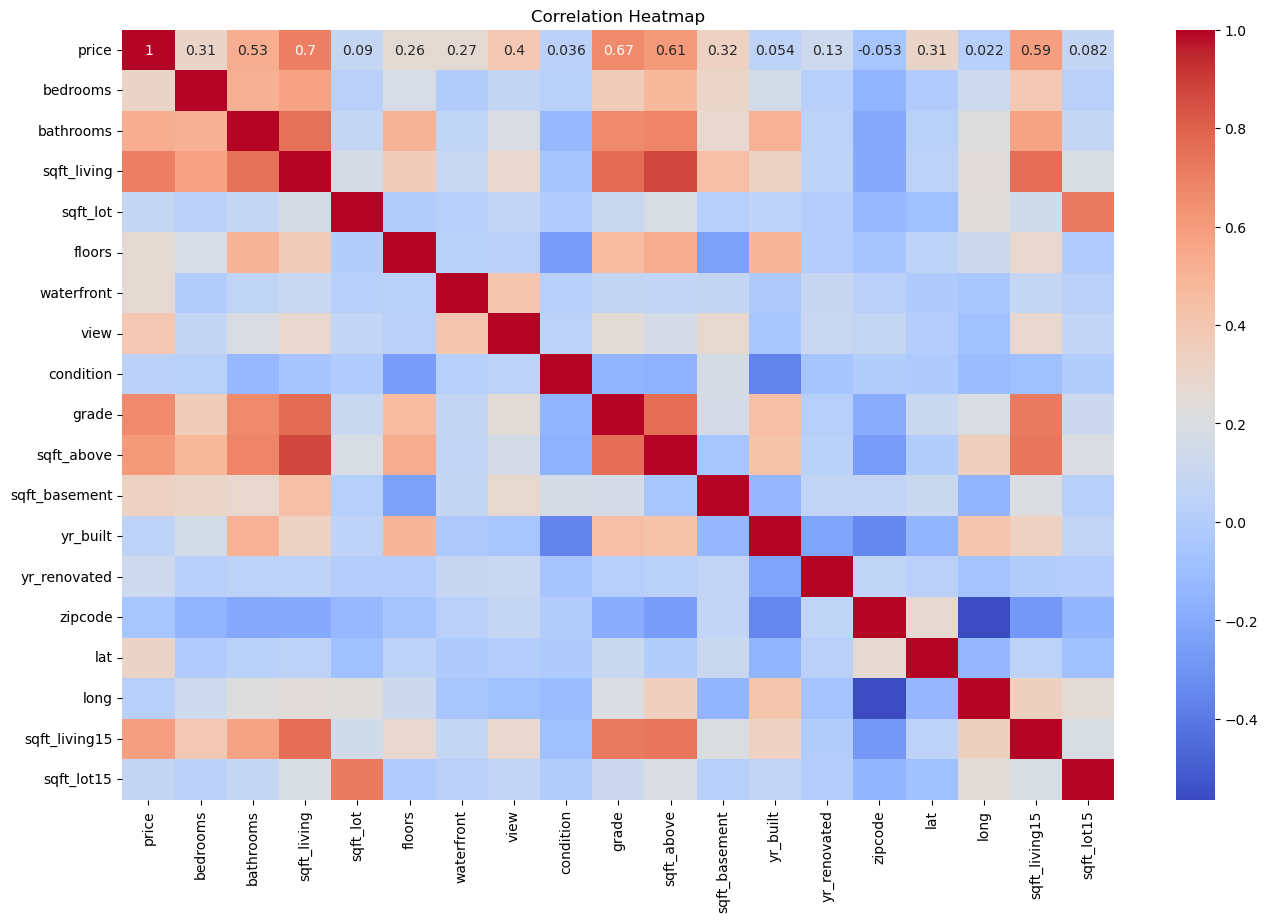

In [8]:
correlation_matrix = df.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Excluding the variables sqft_above, grade, sqft_living15, and sqft_lot15 from consideration due to their strong correlation with certain feature variables.

In [9]:
df = df.drop(['sqft_above','grade','sqft_living15','sqft_lot15'],axis='columns')

Verifying the presence of any duplicate rows.

In [10]:
df.duplicated().sum()

5

Eliminating redundant entries.

In [11]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Gather information regarding waterfront, view and condition feature variables data 

In [12]:
def duplicate_free_data(df,column):
    non_duplicates = df[column].drop_duplicates()
    print(non_duplicates)

In [13]:
duplicate_free_data(df,'waterfront')

0     0
49    1
Name: waterfront, dtype: int64


In [14]:
duplicate_free_data(df,'view')

0      0
15     3
21     4
49     2
282    1
Name: view, dtype: int64


In [15]:
duplicate_free_data(df,'condition')

0     3
3     5
11    4
36    1
38    2
Name: condition, dtype: int64


"view" and "condition" represent ordinal data, while "waterfront" is binary data. In feature engineering, I will do one-hot encoding for "waterfront".

Examine, how many actual floats avaiable in "bathrooms" and "floors" feature variable.

In [16]:
def count_floats(df, columns):
    float_counts = {}
    for col in columns:
        float_counts[col] = sum(df[col].apply(lambda x: isinstance(x, float) and int(x) != x))
    return float_counts 

float_counts = count_floats(df, ['bathrooms', 'floors'])
print(float_counts)

{'bathrooms': 14899, 'floors': 2079}


Since there is too much floats we can't we cannot disregard them. Therefore we will convert them for the nearest integer.

In [17]:
def convert_floats_to_integers(df, columns):
    for col in columns:
        df[col] = df[col].round().astype(int)
    return df

convert_floats_to_integers(df, ['bathrooms', 'floors'])  

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,221900.0,3,1,1180,5650,1,0,0,3,0,1955,0,98178,47.5112,-122.257
1,538000.0,3,2,2570,7242,2,0,0,3,400,1951,1991,98125,47.7210,-122.319
2,180000.0,2,1,770,10000,1,0,0,3,0,1933,0,98028,47.7379,-122.233
3,604000.0,4,3,1960,5000,1,0,0,5,910,1965,0,98136,47.5208,-122.393
4,510000.0,3,2,1680,8080,1,0,0,3,0,1987,0,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2,1530,1131,3,0,0,3,0,2009,0,98103,47.6993,-122.346
21609,400000.0,4,2,2310,5813,2,0,0,3,0,2014,0,98146,47.5107,-122.362
21610,402101.0,2,1,1020,1350,2,0,0,3,0,2009,0,98144,47.5944,-122.299
21611,400000.0,3,2,1600,2388,2,0,0,3,0,2004,0,98027,47.5345,-122.069


# Feature Engineering

Transform the zip code by one-hot encoding format and generate new variables.

In [18]:
df1 = pd.concat([df,pd.get_dummies(df['zipcode'], prefix='zip')],axis='columns')
df1.tail().T

,21608,21609,21610,21611,21612
price,360000.0,400000.0,402101.0,400000.0,325000.0
bedrooms,3,4,2,3,2
bathrooms,2,2,1,2,1
sqft_living,1530,2310,1020,1600,1020
sqft_lot,1131,5813,1350,2388,1076
...,...,...,...,...,...
zip_98177,False,False,False,False,False
zip_98178,False,False,False,False,False
zip_98188,False,False,False,False,False
zip_98198,False,False,False,False,False


Omitting the final column of the zip code, as it can be represent from the others.

In [19]:
df1 = df1.drop(['zip_98199'],axis='columns')

I am performing a similar one-hot encoding process for the "waterfront" column and eliminating the column where "view"==1.

In [20]:
df1 = pd.concat([df1,pd.get_dummies(df1['waterfront'], prefix='water')],axis='columns')
df1 = df1.drop(['waterfront','water_1'],axis='columns')

I refered Clustering longitude and latitude from 2 persons
https://github.com/qingkaikong/blog/tree/master/28_DBSCAN
https://github.com/Bashinim/Projects/blob/74859c6e2b496918b9e9d2dafc50e30b280c430e/Predicting%20House%20Price%20with%20Machine%20Learning%20Models.ipynb

Creating the cordinate matrix 

In [21]:
coords = df1[['lat', 'long']].values

Finding optimum clusters and outliers

In [22]:
kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian

db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', \
            metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
n_clusters = len(set(cluster_labels))

# cluster_labels = -1 means outliers
clusters = \
    pd.Series([coords[cluster_labels == n] for n in range(-1, n_clusters)])
print(clusters.count())

37


Following loop returns the center-most point from a cluster by taking a set of points (i.e., a cluster) and returning the point within it that is nearest to some reference point (in this case, the cluster’s centroid):

In [23]:
lats = []
lons = []

for cluster in clusters:
    if len(cluster)>0:
        centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
        centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
        lats.append(tuple(centermost_point)[0])
        lons.append(tuple(centermost_point)[1])

rep_points = pd.DataFrame({'long':lons, 'lat':lats})

Pulling the full row from the original data set where the latitude and longitude columns match the representative point’s latitude and longitude.

In [24]:
def get_cmap(N):
    '''
    Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.
    '''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='nipy_spectral') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

Pulling full row from the original data set where the latitude and longitude columns match the representative point’s latitude and longitude.

In [25]:
rs = rep_points.apply(lambda row: df1[(df1['lat']==row['lat']) & (df1['long']==row['long'])].iloc[0], axis=1)

Plotting the final reduced set of data points versus the original full set to see how they compare.

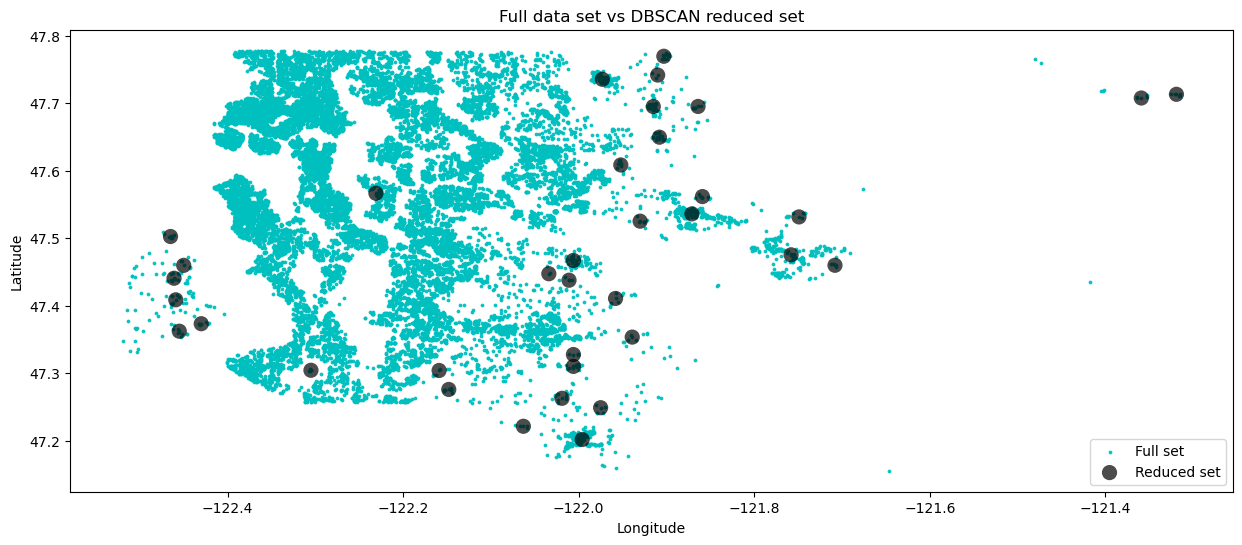

In [26]:
fig, ax = plt.subplots(figsize=[15, 6])
df_scatter = ax.scatter(df['long'], df['lat'], c='c', alpha=0.9, s=3)
rs_scatter = ax.scatter(rs['long'], rs['lat'], c='black', edgecolor='None', alpha=0.7, s=120)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

Adding the clusture lable of each data point to the main dataframe.

In [27]:
df1['clust'] = cluster_labels

Performing one-hot-encoding for clusters.

In [28]:
df1 = pd.concat([df1,pd.get_dummies(df1['clust'], prefix='cluster')],axis=1)

I wanted to see how many data points couldnt capture to a cluster

In [29]:
len(df1[df1.clust == -1])

196

The size of this figure is relatively small when compared to the dataset's magnitude, thus indicating the effectiveness of our clustering method.

Removing the latitude and longitude

In [30]:
df1 = df1.drop(['lat','long'],axis='columns')

Next step is to eliminate the outliers in prices. To achieve this, I am creating a new variable titled 'rice_per_sqft', as using the price alone would not be suitable.

In [31]:
df1['price_per_sqft'] =df1['price']*1000/df1['sqft_living']

Creating a function to eliminate all the prices per square foot of living space that are more than two standard deviations away for each cluster.

In [32]:
def remove_pps_outliers(df):
    df_out= pd.DataFrame()
    for key, subdf in df.groupby('clust'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>=(m-2*st)) & (subdf.price_per_sqft<=(m+2*st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df1 = remove_pps_outliers(df1)
df1 = df1.drop(['zipcode','clust'],axis='columns')
df1.shape

(20631, 118)

We retained a significant portion of our data following the removal of outliers.

Creating a distribution plot to visualize the effects prior to and subsequent to the removal of outliers.

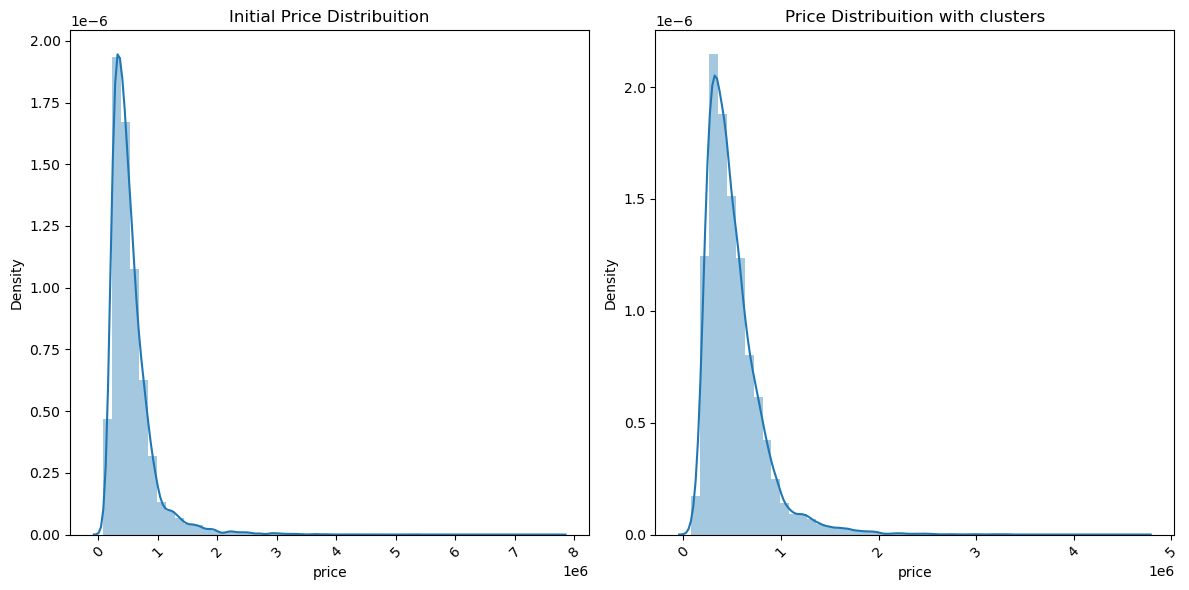

In [33]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.title('Initial Price Distribuition')
plt.xticks(rotation = 45)
sns.distplot(df['price'])

plt.subplot(1, 2, 2)
plt.title('Price Distribuition with clusters')
plt.xticks(rotation = 45)
sns.distplot(df1['price'])

plt.tight_layout()
plt.show()

The significant improvement can be observed through the reduction of the right tail.

# Model building

Spliting the data to feature variable and target variable.

In [34]:
X = df1.drop(columns='price',axis='Columns')
y = df1['price']

Pipeline to find the optimal algorthm and its corresponding parameters.

In [35]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model' : LinearRegression(),
            'params' : {}
        },
        'lasso': {
            'model' : Lasso(),
            'params' : {
                'alpha' : [1,2],
                'selection' : ['random', 'cycle']
            }
        },
         'ridge': {
            'model' : Ridge(),
            'params' : {
                'alpha' : [1,2],
                'solver' : ['auto', 'svd']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params':{
                'criterion':['mse','friedman_mse'],
                'splitter':['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name,config in algos.items():
        gs=GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model':algo_name,
            'best_score':gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

applying the pipeline to preprocess data

In [36]:
find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.929439,{}
1,lasso,0.929458,"{'alpha': 2, 'selection': 'random'}"
2,ridge,0.929455,"{'alpha': 1, 'solver': 'auto'}"
3,decision_tree,0.994070,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


The optimal model is a decision tree employing the criterion "friedman_mse" with the best splitter.